Ocular Disease Recognition Classification through Neural Networks 

In [80]:
# libraries
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json

In [81]:
def dataFrame():
    DataSet = pd.read_csv('C:/Users/marcv/OneDrive/Documents/full_df.csv')
    DataSet['filename'] = 'C:/Users/marcv/OneDrive/Documents/preprocessed_images/' + DataSet['filename']
    DataSet['Left-Fundus'] = 'C:/Users/marcv/OneDrive/Documents/preprocessed_images/' +DataSet['Left-Fundus']
    DataSet['Right-Fundus'] = 'C:/Users/marcv/OneDrive/Documents/preprocessed_images/' +DataSet['Right-Fundus']
    DataSet['Line'] = DataSet['Left-Diagnostic Keywords']+ '|'+DataSet['Right-Diagnostic Keywords']
    DataSet = DataSet.drop(['filepath', 'target'], axis =1)
    return DataSet
dataSet = dataFrame()
dataSet.head()

ID  Patient Age Patient Sex  \
0   0           69      Female   
1   1           57        Male   
2   2           42        Male   
3   4           53        Male   
4   5           50      Female   

                                         Left-Fundus  \
0  C:/Users/marcv/OneDrive/Documents/preprocessed...   
1  C:/Users/marcv/OneDrive/Documents/preprocessed...   
2  C:/Users/marcv/OneDrive/Documents/preprocessed...   
3  C:/Users/marcv/OneDrive/Documents/preprocessed...   
4  C:/Users/marcv/OneDrive/Documents/preprocessed...   

                                        Right-Fundus  \
0  C:/Users/marcv/OneDrive/Documents/preprocessed...   
1  C:/Users/marcv/OneDrive/Documents/preprocessed...   
2  C:/Users/marcv/OneDrive/Documents/preprocessed...   
3  C:/Users/marcv/OneDrive/Documents/preprocessed...   
4  C:/Users/marcv/OneDrive/Documents/preprocessed...   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O labels  \
0                           normal fundus  0  0  0  1  0  0  0  0  ['N']   
1                           normal fundus  1  0  0  0  0  0  0  0  ['N']   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  ['D']   

                                            filename  \
0  C:/Users/marcv/OneDrive/Documents/preprocessed...   
1  C:/Users/marcv/OneDrive/Documents/preprocessed...   
2  C:/Users/marcv/OneDrive/Documents/preprocessed...   
3  C:/Users/marcv/OneDrive/Documents/preprocessed...   
4  C:/Users/marcv/OneDrive/Documents/preprocessed...   

                                                Line  
0                             cataract|normal fundus  
1                        normal fundus|normal fundus  
2  laser spot，moderate non proliferative retinopa...  
3  macular epiretinal membrane|mild nonproliferat...  
4  moderate non proliferative retinopathy|moderat...

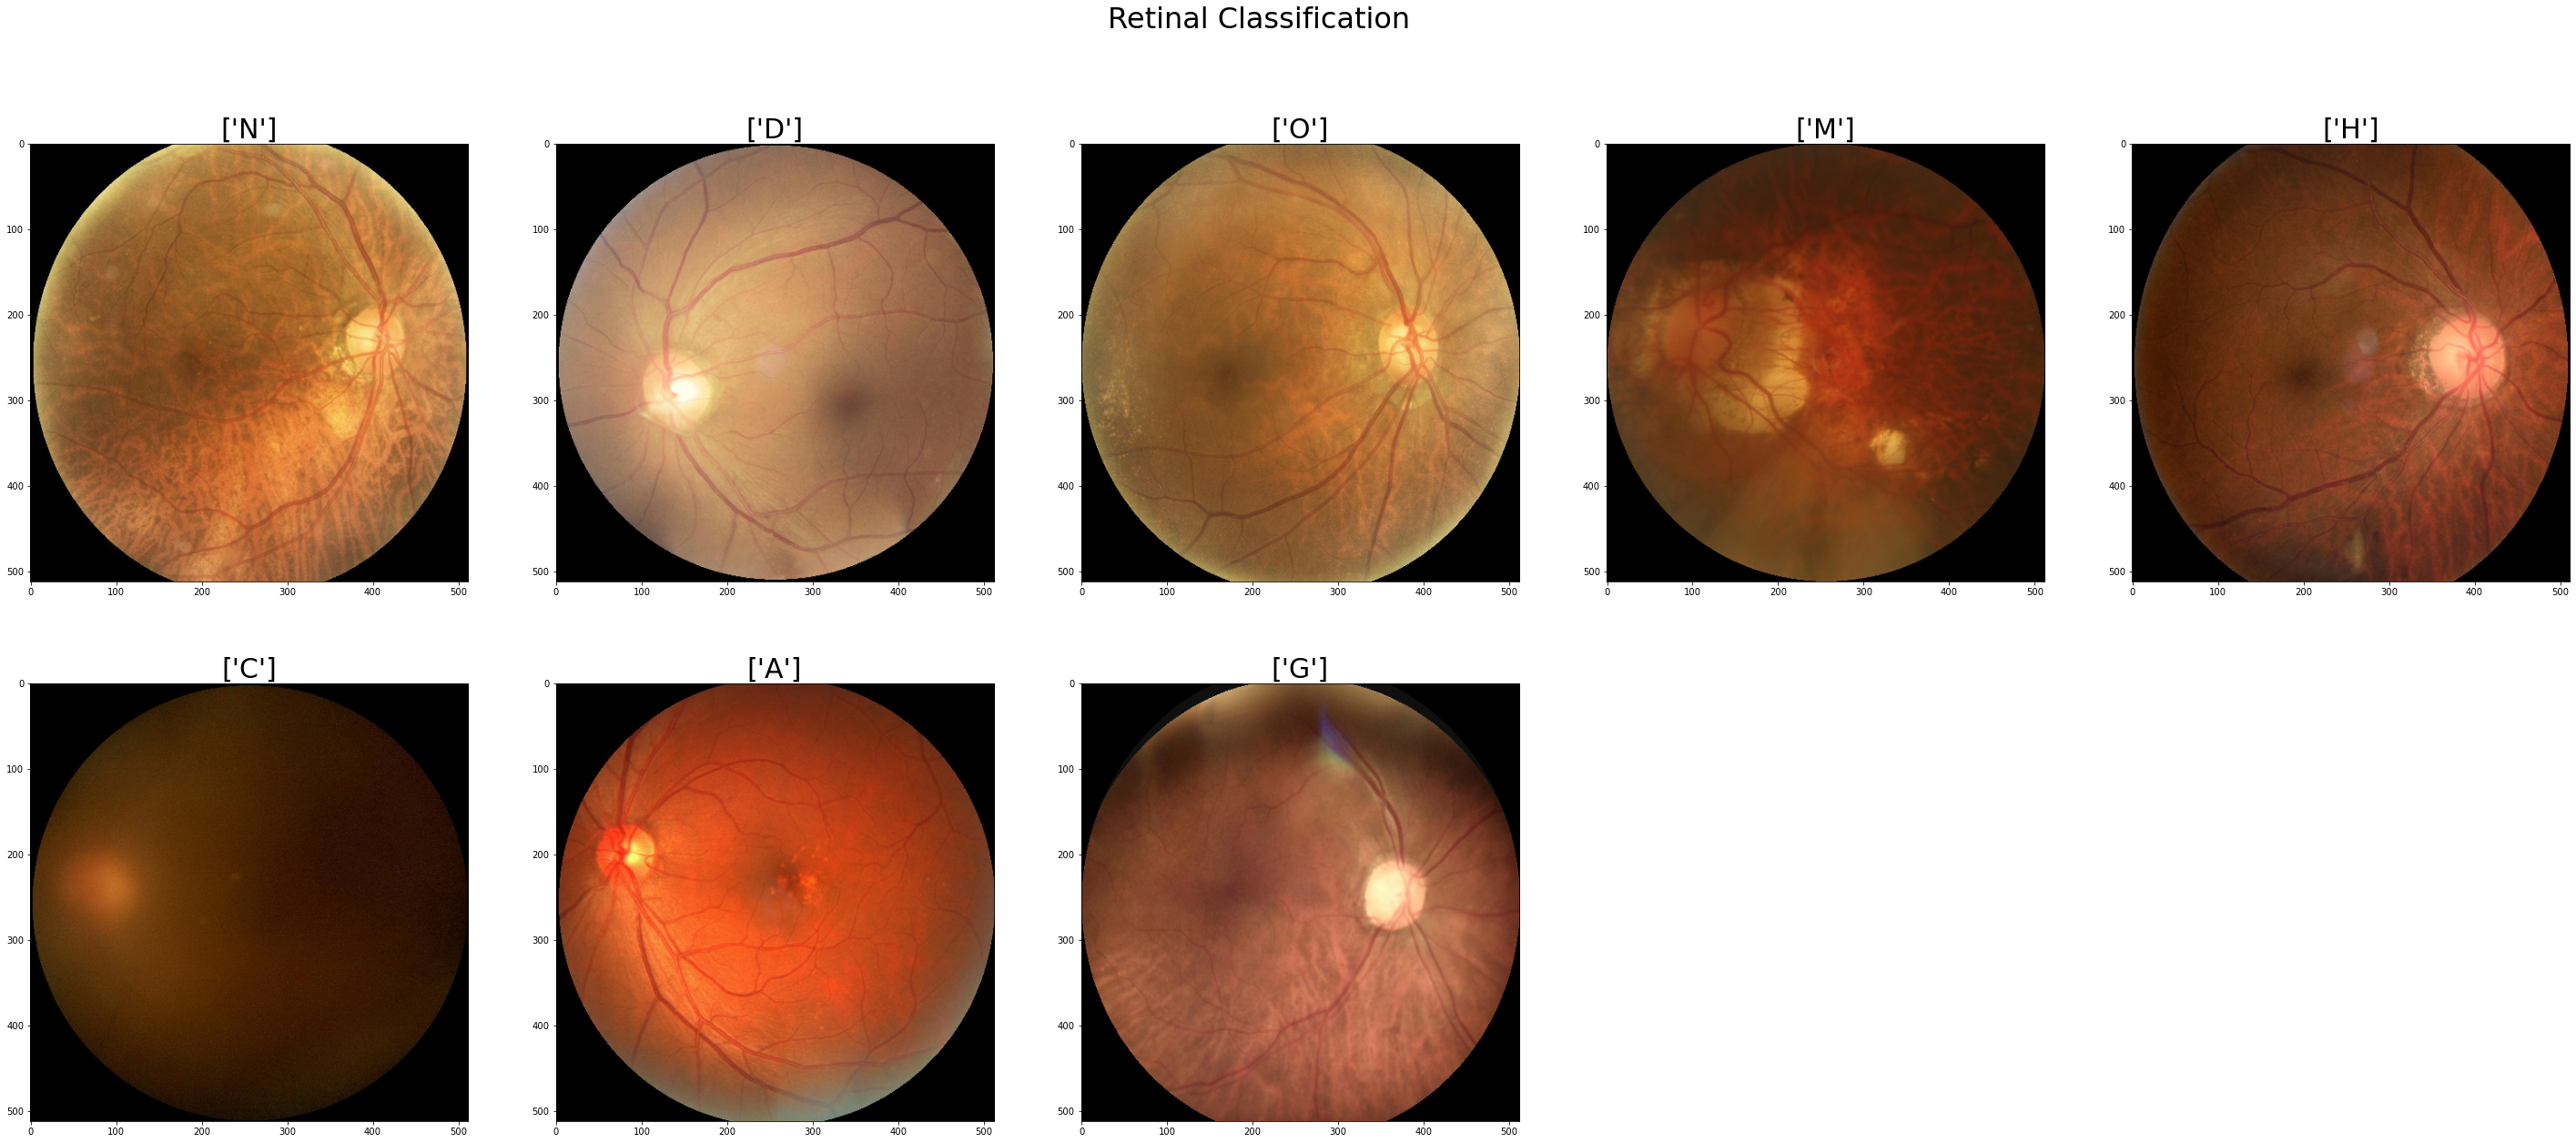

In [82]:
i = 1
f = plt.figure(figsize=(50,20))
for Class in dataSet['labels'].unique():
    seg = dataSet[dataSet['labels']==Class]
    address = seg.sample().iloc[0]['filename']
    img = mpimg.imread(address)
    axes = plt.subplot(2,5, i)
    axes = plt.imshow(img)
    axes = plt.title(Class, fontsize = 30)
    i = i +1
plt.suptitle("Retinal Classification", size = 32)
plt.show()

In [83]:
w, h = 16,16
listImg = os.listdir('C:/Users/marcv/OneDrive/Documents/preprocessed_images/')
string = 'C:/Users/marcv/OneDrive/Documents/preprocessed_images/'
listtemp = list(map(lambda orig_string: string + orig_string, listImg))
#print(listtemp)
index = []
for i in dataSet.index:
    if dataSet.iloc[i]['Left-Fundus'] in listtemp and dataSet.iloc[i]['Right-Fundus'] in listtemp:
        continue
    else:
        index.append(i)

In [84]:
dataSet = dataSet.drop(index)

In [85]:
print(len(dataSet))

6068


In [86]:
left = []
for location in tqdm(dataSet[:]['Left-Fundus']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    left.append(img)

100%|█████████████████████████████████████████████████████████████████████████████| 6068/6068 [00:08<00:00, 679.42it/s]


In [87]:
right = []
for location in tqdm(dataSet[:]['Right-Fundus']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    right.append(img)

#inputting the data as X values
xLeft = np.array(left)
xRight = np.array(right)

100%|█████████████████████████████████████████████████████████████████████████████| 6068/6068 [00:09<00:00, 627.66it/s]


In [88]:
y = np.array(np.array(dataSet.iloc[:][['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O',]]))

In [89]:
final_class = 8
def model_b():
    inp1 = Input(shape=(xLeft.shape[1],xLeft.shape[2],1,))
    inp2 = Input(shape=(xRight.shape[1],xRight.shape[2],1,))
    new_input = Input(shape=(xLeft.shape[1],xLeft.shape[2], 3))
    conv1 = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp1)
    i1 = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=new_input, input_shape=None, pooling='avg',)(conv1)
    conv2= Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp2)
    i2 = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_tensor=new_input, input_shape=None,pooling='avg',)(conv2)
    merge = concatenate([i1,i2])
    class1 = Dense(1024, activation='relu')(merge)
    class1 = Dense(512, activation='relu')(class1)
    class1 = Dense(256, activation='relu')(class1)
    class1 = Dense(128, activation='relu')(class1)
    class1 = Dense(64, activation='relu')(class1)
    output = Dense(final_class, activation='sigmoid')(class1)
    model = Model(inputs=[inp1,inp2], outputs=output)
    return model
md = model_b()

In [98]:
xTrain1, xTest1, xTrain2, xTest2, yTrain, yTest = train_test_split(xLeft, xRight, y, test_size= 0.20, random_state=42)
xTrain1, xTrue1, xTrain2, xTrue2, yTrain, yTrue = train_test_split(xTrain1, xTrain2, yTrain, test_size=0.20, random_state = 42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
def LR_verify():
        model = model_b()
        METRICS = ['accuracy']  
        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=METRICS)
        history = model.fit([xLeft,xRight], y, epochs=100 ,verbose=1,shuffle = True, validation_data=([xTrue1,xTrue2],yTrue))
        return model,history 
model,history= LR_verify()

Epoch 1/100
190/190 [==============================] - 359s 2s/step - loss: 0.3720 - accuracy: 0.3568 - val_loss: 0.4049 - val_accuracy: 0.3903
Epoch 2/100
190/190 [==============================] - 355s 2s/step - loss: 0.3594 - accuracy: 0.3568 - val_loss: 2.0161 - val_accuracy: 0.3769
Epoch 3/100
190/190 [==============================] - 325s 2s/step - loss: 0.3584 - accuracy: 0.3601 - val_loss: 0.3786 - val_accuracy: 0.4058
Epoch 4/100
190/190 [==============================] - 387s 2s/step - loss: 0.3557 - accuracy: 0.3566 - val_loss: 0.4040 - val_accuracy: 0.3872
Epoch 5/100
190/190 [==============================] - 380s 2s/step - loss: 0.3522 - accuracy: 0.3696 - val_loss: 1.2847 - val_accuracy: 0.4037
Epoch 6/100
190/190 [==============================] - 380s 2s/step - loss: 0.3509 - accuracy: 0.3711 - val_loss: 0.3986 - val_accuracy: 0.4315
Epoch 7/100
190/190 [==============================] - 350s 2s/step - loss: 0.3478 - accuracy: 0.3771 - val_loss: 0.3622 - val_accuracy:

190/190 [==============================] - 469s 2s/step - loss: 0.2077 - accuracy: 0.6941 - val_loss: 0.2290 - val_accuracy: 0.6498
Epoch 58/100
190/190 [==============================] - 473s 2s/step - loss: 0.2392 - accuracy: 0.6350 - val_loss: 0.3544 - val_accuracy: 0.3635
Epoch 59/100
190/190 [==============================] - 481s 3s/step - loss: 0.2782 - accuracy: 0.5567 - val_loss: 0.2603 - val_accuracy: 0.6066
Epoch 60/100
190/190 [==============================] - 485s 3s/step - loss: 0.2379 - accuracy: 0.6442 - val_loss: 0.2646 - val_accuracy: 0.6416
Epoch 61/100
190/190 [==============================] - 518s 3s/step - loss: 0.2370 - accuracy: 0.6486 - val_loss: 2.7712 - val_accuracy: 0.5510
Epoch 62/100
190/190 [==============================] - 524s 3s/step - loss: 0.2183 - accuracy: 0.6786 - val_loss: 0.2422 - val_accuracy: 0.6519
Epoch 63/100
190/190 [==============================] - 419s 2s/step - loss: 0.2075 - accuracy: 0.6933 - val_loss: 0.2001 - val_accuracy: 0.718

In [99]:
model_json = model.to_json()
name = 'ODIR_ResNet'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)

In [100]:
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# loading the weights into new model
loaded_model.load_weights("./"+name+".h5")

Training the Model 

In [101]:
METRICS = ['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives()]  
loaded_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=METRICS)
score = loaded_model.evaluate([xLeft,xRight], y, verbose=0)
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.35379287600517273
accuracy : 0.5675675868988037
false_negatives_7 : 3610.0
false_positives_7 : 2190.0
precision_7 : 0.6072453260421753
recall_7 : 0.4839908480644226
true_negatives_7 : 39358.0
true_positives_7 : 3386.0


Validating the Model

In [102]:
METRICS = ['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives()]  
loaded_model.compile( optimizer='Adam', loss='binary_crossentropy', metrics=METRICS)
score = loaded_model.evaluate([xTrue1,xTrue2], yTrue, verbose=0)
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.3611273467540741
accuracy : 0.5767250061035156
false_negatives_8 : 577.0
false_positives_8 : 344.0
precision_8 : 0.6160714030265808
recall_8 : 0.48892825841903687
true_negatives_8 : 6295.0
true_positives_8 : 552.0


Testing the Model

In [103]:
METRICS = ['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives()]  
loaded_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=METRICS)
score = loaded_model.evaluate([xTest1,xTest2], yTest, verbose=0)
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.3576655387878418
accuracy : 0.5593080520629883
false_negatives_9 : 727.0
false_positives_9 : 438.0
precision_9 : 0.60326087474823
recall_9 : 0.4781047999858856
true_negatives_9 : 7881.0
true_positives_9 : 666.0


In [104]:
y_out = loaded_model.predict([xTest1,xTest2])
y_out = y_out.round()
report = classification_report(yTest, y_out,target_names=['N','D','G','C','A','H','M','O'],output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
N              0.641361  0.606436  0.623410    404.0
D              0.558394  0.733813  0.634197    417.0
G              0.866667  0.188406  0.309524     69.0
C              0.854545  0.635135  0.728682     74.0
A              0.428571  0.039474  0.072289     76.0
H              0.500000  0.151515  0.232558     33.0
M              0.629630  0.326923  0.430380     52.0
O              0.500000  0.111940  0.182927    268.0
micro avg      0.603261  0.478105  0.533440   1393.0
macro avg      0.622396  0.349205  0.401746   1393.0
weighted avg   0.596417  0.478105  0.485405   1393.0
samples avg    0.539127  0.502883  0.512768   1393.0